Modules nécessaires : 

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

from HiggsML.ingestion import Ingestion
from HiggsML.datasets import download_dataset
from sample_code_submission.neural_network import NeuralNetwork
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import RandomState
import warnings
import os
import sys

warnings.filterwarnings("ignore")

Charger les données : 

In [2]:
data = download_dataset(
    "blackSwan_data"
)  # change to "blackSwan_data" for the actual data

# load train set
data.load_train_set()
data_set = data.get_train_set()

2025-06-04 15:33:16,152 - HiggsML.datasets     - INFO     - Handling as dataset name: blackSwan_data
2025-06-04 15:33:16,153 - HiggsML.datasets     - INFO     - Current working directory: c:\Users\mexyb\Documents\ST4_blackswan\Higgs_collaboration_A
2025-06-04 15:33:16,168 - HiggsML.datasets     - INFO     - Total rows: 2000000
2025-06-04 15:33:16,170 - HiggsML.datasets     - INFO     - Test size: 600000
2025-06-04 15:33:16,282 - HiggsML.datasets     - INFO     - Selected train size: 1400000
2025-06-04 15:33:17,891 - HiggsML.datasets     - INFO     - Data loaded successfully


In [3]:
target = data_set["labels"]
weights = data_set["weights"]
detailed_label = data_set["detailed_labels"]
keys = np.unique(detailed_label)

Direction

In [4]:
root_dir = os.getcwd()
print("Root directory is", root_dir)
submission_dir = os.path.join(root_dir, "sample_code_submission")

# The directory where results and other outputs from the participant's code will be written
output_dir = os.path.join(root_dir, "sample_result_submission")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Root directory is c:\Users\mexyb\Documents\ST4_blackswan\Higgs_collaboration_A


Import Submission Model

In [5]:
path.append(submission_dir)
from model import Model

Testing Settings

In [6]:
TEST_SETTINGS = {
    "systematics": {  # Systematics to use
        "tes": False,  # tau energy scale
        "jes": False,  # jet energy scale
        "soft_met": False,  # soft term in MET
        "ttbar_scale": False,  # W boson scale factor
        "diboson_scale": False,  # Diboson scale factor
        "bkg_scale": False,  # Background scale factor
    },
    "num_pseudo_experiments": 25,  # Number of pseudo-experiments to run per set
    "num_of_sets": 25,  # Number of sets of pseudo-experiments to run
}

RANDOM_SEED = 42


In [7]:
test_settings = TEST_SETTINGS.copy()

random_state = np.random.RandomState(RANDOM_SEED)
test_settings["ground_truth_mus"] = (
    random_state.uniform(0.1, 3, test_settings["num_of_sets"])
).tolist()

random_settings_file = os.path.join(output_dir, "test_settings.json")
with open(random_settings_file, "w") as f:
    json.dump(test_settings, f)

Boucle sur "Ingestion" en faisant varier epochs

Fonction bouclée: 

Significance

In [8]:

def optimization(train_data): 
    L_batchsize = [8,16,32,64,128,256,512,1024,2048]
    sigmax = 0
  
    for k in range(len(L_batchsize)):
        ingestion = Ingestion(data)
        # initialize submission
        ingestion.init_submission(Model, "NN")
        ingestion.model.model.batchsize = L_batchsize[k]
        print(ingestion.model.model.batchsize)
        ingestion.fit_submission()
        sig1 = ingestion.model.model.significance(test_labels=ingestion.model.training_set["labels"],test_weights=ingestion.model.training_set["weights"])
        #visualisation des données :
        if sig1>sigmax: 
            sigmax = sig1
            batchsize_max = L_batchsize[k]
    return sigmax, batchsize_max



Il y a plusieurs problématique : 
Comment modifier une variable epochs de notre 

Lancement de la boucle

2025-06-04 15:33:19,617 - HiggsML.ingestion    - INFO     - Initializing Submmited Model
2025-06-04 15:33:19,632 - HiggsML.datasets     - INFO     - Selected train size: 50000
2025-06-04 15:33:20,270 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-06-04 15:33:20,328 - HiggsML.datasets     - INFO     - Selected train size: 50000


Training Data:  (50000, 28)
Training Labels:  (50000,)
Training Weights:  (50000,)
sum_signal_weights:  676.7763230113688
sum_bkg_weights:  105042.22367691167


2025-06-04 15:33:20,984 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-06-04 15:33:21,041 - HiggsML.datasets     - INFO     - Selected train size: 50000



Valid Data:  (50000, 28)
Valid Labels:  (50000,)
Valid Weights:  (50000,)
sum_signal_weights:  678.430996651876
sum_bkg_weights:  105040.56900327088


2025-06-04 15:33:21,765 - HiggsML.datasets     - INFO     - Data loaded successfully



Holdout Data:  (50000, 28)
Holdout Labels:  (50000,)
Holdout Weights:  (50000,)
sum_signal_weights:  665.0216870742289
sum_bkg_weights:  105053.97831284867
 
 
Training Data:  (50000, 28)
DEBUG: model_type = 'NN'


2025-06-04 15:33:22,078 - HiggsML.ingestion    - INFO     - Calling fit method of submitted model


 Model is NN
8
Epoch 1/5
6250/6250 - 20s - 3ms/step - accuracy: 0.7963 - loss: 1.9835
Epoch 2/5
6250/6250 - 19s - 3ms/step - accuracy: 0.8109 - loss: 1.8953
Epoch 3/5
6250/6250 - 16s - 3ms/step - accuracy: 0.8149 - loss: 1.8771
Epoch 4/5
6250/6250 - 17s - 3ms/step - accuracy: 0.8164 - loss: 1.8564
Epoch 5/5
6250/6250 - 16s - 3ms/step - accuracy: 0.8174 - loss: 1.8455
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
predictions.shape: (45857,)
labels.shape: ()
weights.shape: ()
score shape before threshold (45857,)
score shape after threshold (45857,)
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
predictions.shape: (45857,)
labels.shape: ()
weights.shape: ()
1434/1434 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
predictions.shape: (45857,)
labels.shape: ()
weights.shape: ()
saved_info {'beta': np.float64(16383.39351787139), 'gamma': np.float64(489.0887389215273), 'tes_fit': <function tes_fitter.<locals>.fit_function at 0x000001BB046EC790>, 'jes_fit': <function jes_fitter.<locals>.fit_function at 0x000001BB0

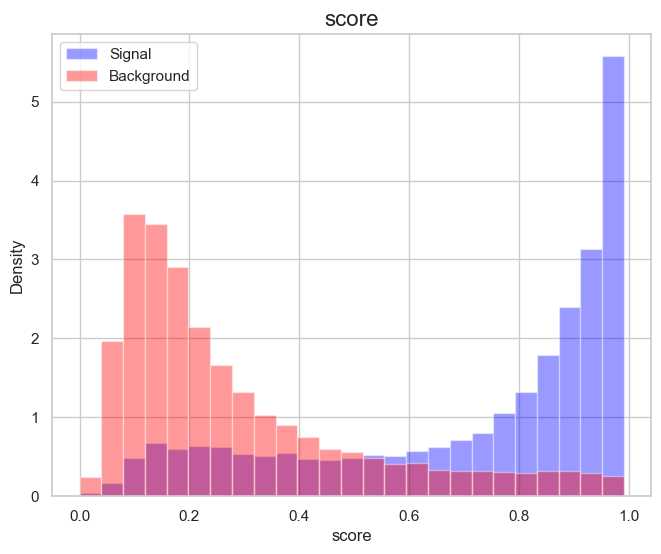

keys ['diboson' 'htautau' 'ttbar' 'ztautau']
keys 2 dict_keys(['diboson', 'htautau', 'ttbar', 'ztautau'])
htautau (30,)


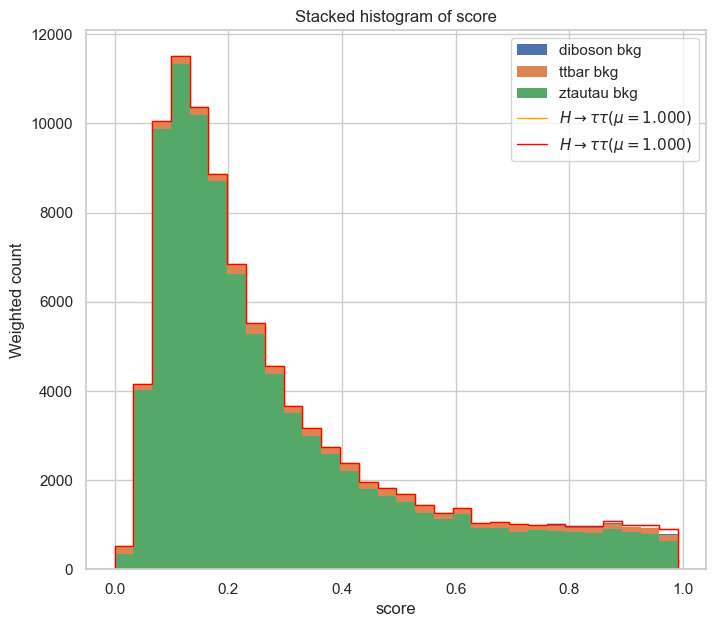

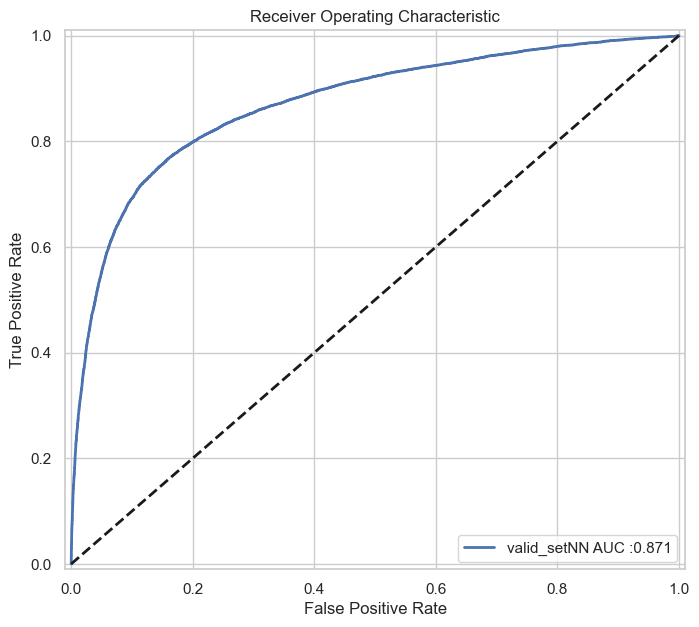

2025-06-04 15:35:13,152 - HiggsML.ingestion    - INFO     - Initializing Submmited Model
2025-06-04 15:35:13,165 - HiggsML.datasets     - INFO     - Selected train size: 50000
2025-06-04 15:35:13,723 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-06-04 15:35:13,764 - HiggsML.datasets     - INFO     - Selected train size: 50000


Training Data:  (50000, 28)
Training Labels:  (50000,)
Training Weights:  (50000,)
sum_signal_weights:  666.3214341994451
sum_bkg_weights:  105052.67856572334


2025-06-04 15:35:14,235 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-06-04 15:35:14,274 - HiggsML.datasets     - INFO     - Selected train size: 50000



Valid Data:  (50000, 28)
Valid Labels:  (50000,)
Valid Weights:  (50000,)
sum_signal_weights:  676.9588755420943
sum_bkg_weights:  105042.04112438131


2025-06-04 15:35:14,766 - HiggsML.datasets     - INFO     - Data loaded successfully
2025-06-04 15:35:14,869 - HiggsML.ingestion    - INFO     - Calling fit method of submitted model



Holdout Data:  (50000, 28)
Holdout Labels:  (50000,)
Holdout Weights:  (50000,)
sum_signal_weights:  676.9333743965932
sum_bkg_weights:  105042.066625526
 
 
Training Data:  (50000, 28)
DEBUG: model_type = 'NN'
 Model is NN
16
Epoch 1/5
3125/3125 - 10s - 3ms/step - accuracy: 0.7937 - loss: 2.0026
Epoch 2/5
3125/3125 - 10s - 3ms/step - accuracy: 0.8114 - loss: 1.8998
Epoch 3/5
3125/3125 - 10s - 3ms/step - accuracy: 0.8149 - loss: 1.8771
Epoch 4/5


KeyboardInterrupt: 

In [9]:
optimization(data_set)